In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# --- DÉFINITION DES CHEMINS ---
PROJECT_ROOT_ABSOLUTE = "/home/onyxia/work/Gestion-portefeuille/"

try:
    ROOT_DIR = Path(PROJECT_ROOT_ABSOLUTE)
except Exception:
    ROOT_DIR = Path.cwd()

INTERIM_DATA_PATH = ROOT_DIR / "data" / "interim"
PROCESSED_DATA_PATH = ROOT_DIR / "data" / "processed"
INPUT_FILENAME = "cac40_interim_features.csv"

# --- 1. FONCTION DE CHARGEMENT ET PRÉPARATION ---

def load_and_prepare_data():
    """Charge les données, sélectionne la dernière date et met à l'échelle."""
    filepath = INTERIM_DATA_PATH / INPUT_FILENAME
    if not filepath.exists():
        print(f"❌ Erreur : Fichier d'entrée non trouvé à {filepath}. Relancez l'étape 2.")
        return None, None

    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    latest_date = df['Date'].max()
    df_latest = df[df['Date'] == latest_date].copy().set_index('Ticker')

    FEATURES = ['Volatility', 'Sharpe_Ratio_20D', 'Performance_20D', 'Volume', 'Dividends']

    X = df_latest[FEATURES].copy()

    # Nettoyage et Imputation
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())

    # Normalisation
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=FEATURES, index=X.index)

    return X_scaled, df_latest

# --- Exécution de l'exploration ---
X_scaled, df_latest = load_and_prepare_data()

if X_scaled is None:
    print("Impossible de continuer sans données préparées.")
else:
    # ----------------------------------------------------
    # I. DIAGNOSTIC K (Méthode du Coude)
    # ----------------------------------------------------
    print("\n🔬 Diagnostic : Méthode du Coude pour K Optimal")

    sse = {}  # Sum of Squared Errors
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        sse[k] = kmeans.inertia_

    plt.figure(figsize=(10, 6))
    plt.plot(list(sse.keys()), list(sse.values()), marker='o')
    plt.title('Méthode du Coude pour K Optimal')
    plt.xlabel("Nombre de Clusters (K)")
    plt.ylabel("Somme des Carrés des Erreurs (SSE)")

    # Sauvegarde du plot (pas de show bloquant)
    elbow_path = PROCESSED_DATA_PATH / "diagnostic_elbow_method.png"
    plt.savefig(elbow_path, bbox_inches="tight")
    plt.close()

    # ----------------------------------------------------
    # II. VISUALISATION DES CLUSTERS (PCA)
    # ----------------------------------------------------

    # Réapplique K-Means avec K=4 (valeur choisie)
    K_CHOICE = 4
    kmeans_final = KMeans(n_clusters=K_CHOICE, random_state=42, n_init=10)
    clusters = kmeans_final.fit_predict(X_scaled)
    df_latest['Cluster'] = clusters

    print(f"\n📊 Visualisation de la séparation pour K = {K_CHOICE}")

    # Réduction de dimension (PCA pour 2D)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(
        data=principal_components,
        columns=['PC1', 'PC2'],
        index=df_latest.index
    )

    # Ajouter la colonne Cluster pour la visualisation
    pca_df['Cluster'] = clusters

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        pca_df['PC1'],
        pca_df['PC2'],
        c=pca_df['Cluster'],
        cmap='viridis',
        s=50,
        alpha=0.7
    )

    # Annoter les points avec le ticker
    for i, txt in enumerate(pca_df.index):
        plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=8, alpha=0.8)

    plt.title(f'Segmentation des Actifs du CAC 40 (K={K_CHOICE} - Visualisation PCA)')
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")

    # Légende pour la couleur
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="upper right", title="Clusters")
    plt.gca().add_artist(legend1)

    # Sauvegarde du plot (pas de show bloquant)
    pca_path = PROCESSED_DATA_PATH / "visualization_pca_clusters.png"
    plt.savefig(pca_path, bbox_inches="tight")
    plt.close()

    print(f"\n✅ Figures sauvegardées dans :\n - {elbow_path}\n - {pca_path}")



🔬 Diagnostic : Méthode du Coude pour K Optimal

📊 Visualisation de la séparation pour K = 4


/tmp/ipykernel_34805/1412866049.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (pca_df['PC1'][i], pca_df['PC2'][i]), fontsize=8, alpha=0.8)



✅ Figures sauvegardées dans :
 - /home/onyxia/work/Gestion-portefeuille/data/processed/diagnostic_elbow_method.png
 - /home/onyxia/work/Gestion-portefeuille/data/processed/visualization_pca_clusters.png


K-Means


/tmp/ipykernel_34805/2964731018.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data_filtered['Cluster'] = kmeans.fit_predict(scaled_features)
/tmp/ipykernel_34805/2964731018.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(cluster_data_filtered.Volatility[i],
/tmp/ipykernel_34805/2964731018.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cluster_

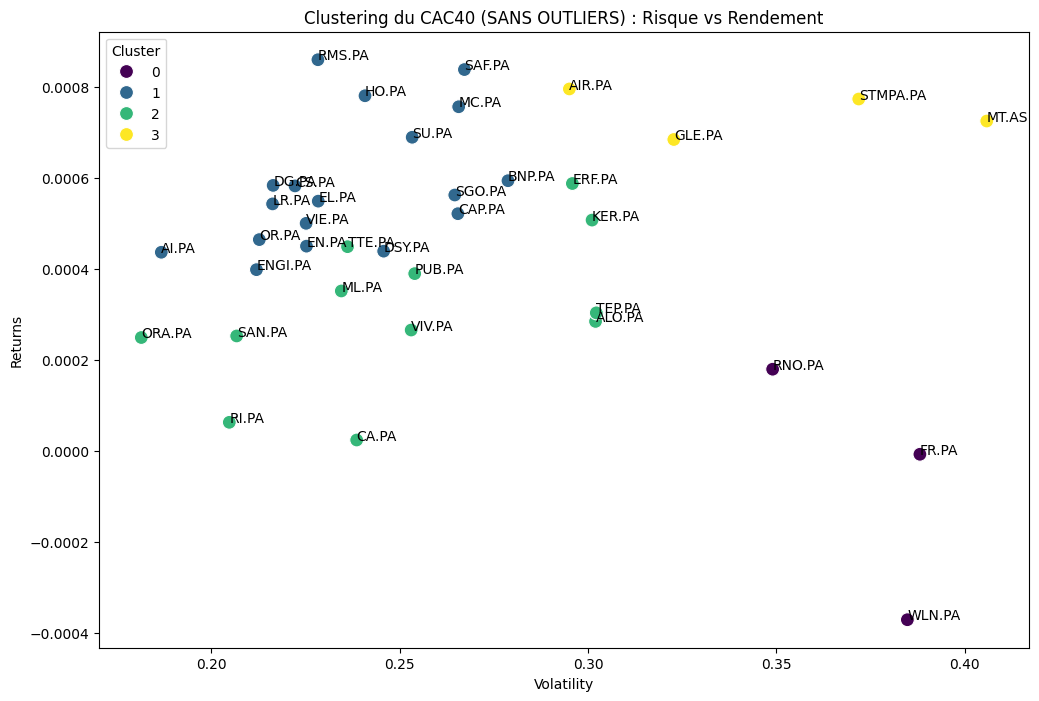

In [4]:
# 1. Chargement du fichier généré à l'étape précédente
df = pd.read_csv("/home/onyxia/work/Gestion-portefeuille/data/interim/cac40_interim_features.csv")

# 2. Agrégation par Ticker (Moyenne des indicateurs)
cluster_data = df.groupby('Ticker').agg({
    'Returns': 'mean',
    'Volatility': 'mean',
    'Sharpe_Ratio_20D': 'mean'
}).dropna()

# --- C'EST ICI QUE TU AJOUTES LE FILTRE ---
# On exclut Atos (ATO.PA) et toute autre valeur aberrante
cluster_data_filtered = cluster_data[cluster_data['Volatility'] < 1.0]

# 3. Normalisation (on utilise maintenant le DataFrame FILTRÉ)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(cluster_data_filtered)

# 4. Clustering K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_data_filtered['Cluster'] = kmeans.fit_predict(scaled_features)

# 5. Visualisation (le graph sera maintenant dilaté et lisible)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cluster_data_filtered, x='Volatility', y='Returns', hue='Cluster', palette='viridis', s=100)

# Ajout des labels pour les 39 actions restantes
for i in range(cluster_data_filtered.shape[0]):
    plt.text(cluster_data_filtered.Volatility[i], 
             cluster_data_filtered.Returns[i], 
             cluster_data_filtered.index[i])

plt.title('Clustering du CAC40 (SANS OUTLIERS) : Risque vs Rendement')
plt.show()

CAH

/tmp/ipykernel_34805/721126094.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='ward')


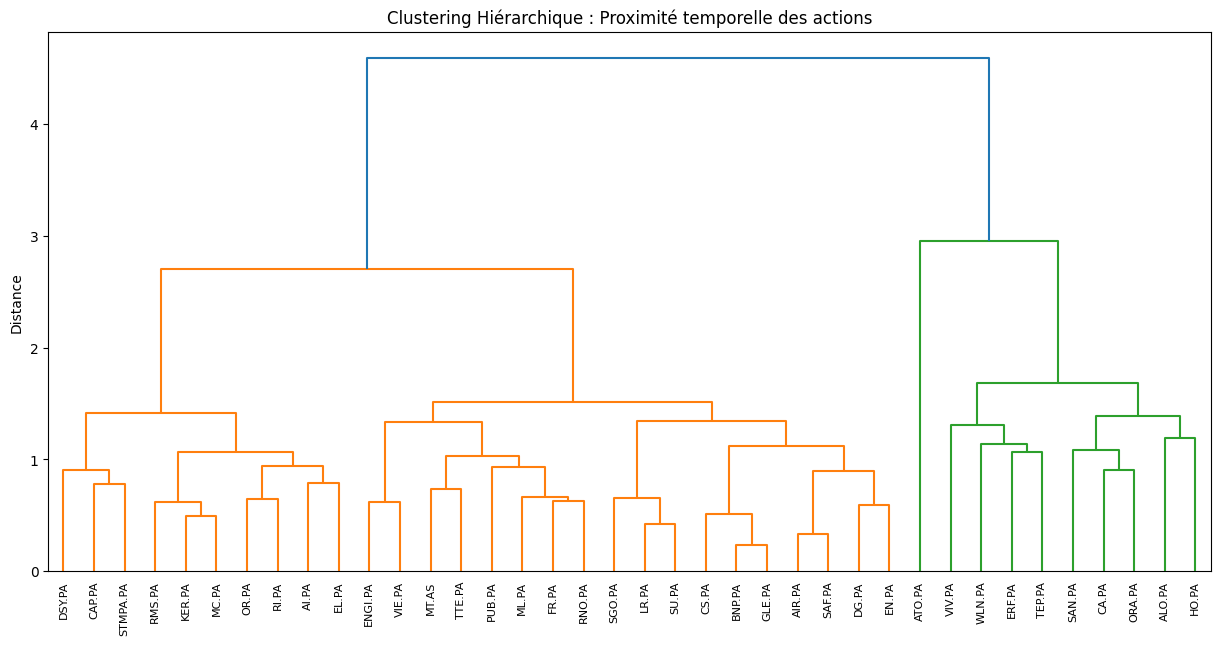

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. On utilise la matrice de corrélation que tu as déjà calculée
# On transforme la corrélation en 'distance' (plus ils sont corrélés, plus la distance est petite)
distance_matrix = 1 - corr_matrix

# 2. Calcul du lien hiérarchique
Z = linkage(distance_matrix, method='ward')

# 3. Affichage du Dendrogramme
plt.figure(figsize=(15, 7))
dendrogram(Z, labels=corr_matrix.index, leaf_rotation=90)
plt.title("Clustering Hiérarchique : Proximité temporelle des actions")
plt.ylabel("Distance")
plt.show()


Matrice de corrélation

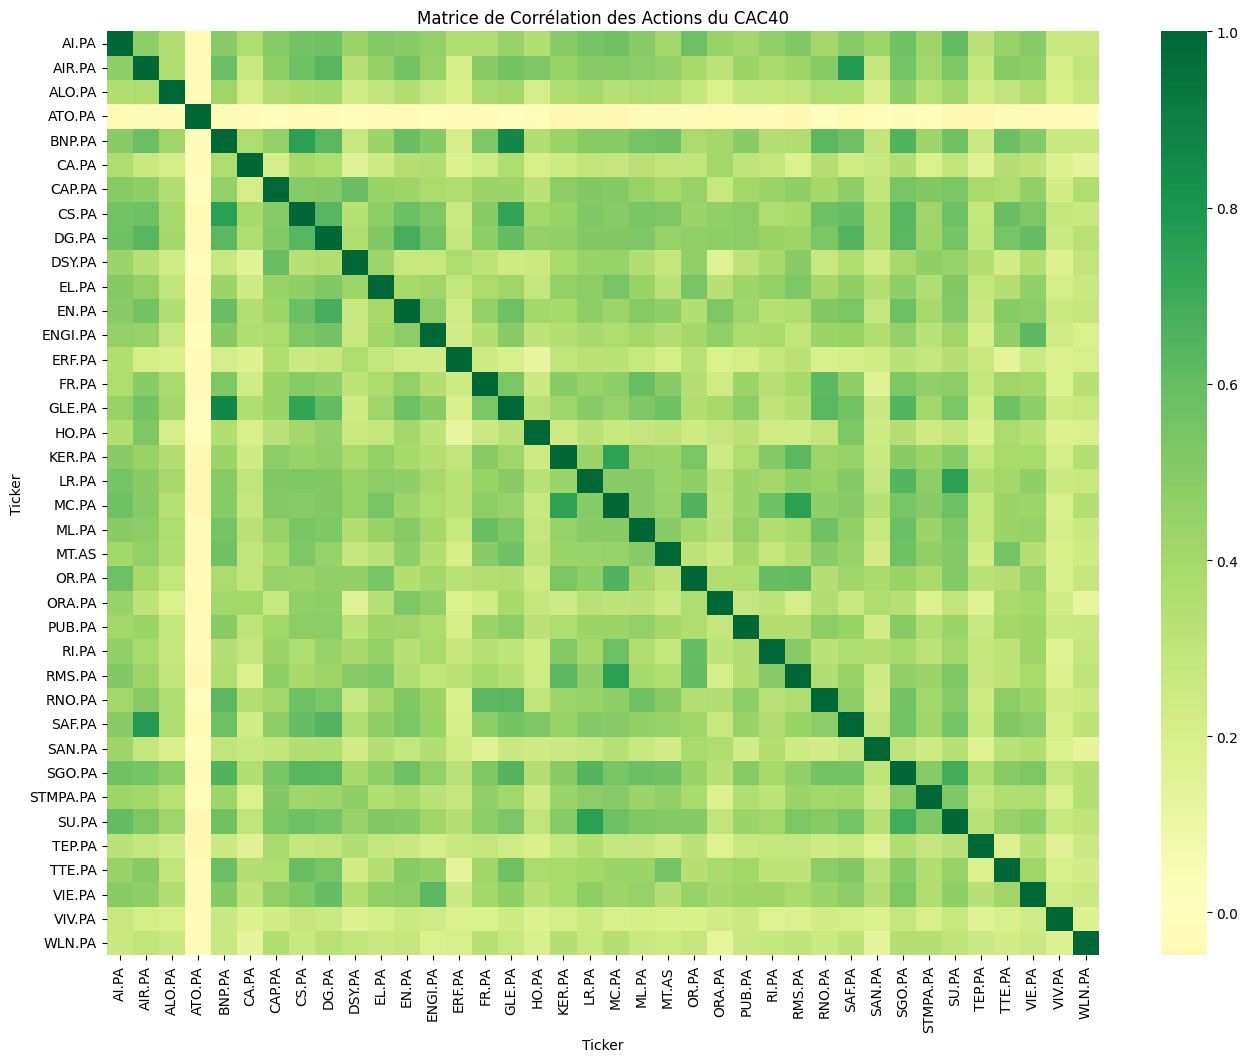

In [5]:
import seaborn as sns

# 1. On repart des rendements quotidiens (il faut pivoter les données)
# On utilise le fichier 'interim' qui contient les rendements par date
df_returns = pd.read_csv("/home/onyxia/work/Gestion-portefeuille/data/interim/cac40_interim_features.csv")
df_pivot = df_returns.pivot(index='Date', columns='Ticker', values='Returns')

# 2. Calcul de la matrice de corrélation de Pearson
corr_matrix = df_pivot.corr()

# 3. Affichage de la Heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='RdYlGn', center=0)
plt.title('Matrice de Corrélation des Actions du CAC40')
plt.show()

MaxDrawdown

In [16]:
# 1. Calcul du MDD 
df_hist = pd.read_csv("/home/onyxia/work/Gestion-portefeuille/data/interim/cac40_interim_features.csv")
def compute_mdd(series):
    rolling_max = series.cummax()
    drawdown = (series - rolling_max) / rolling_max
    return drawdown.min()

mdd_per_ticker = df_hist.groupby('Ticker')['Close'].apply(compute_mdd)

# 2. Ajout au DataFrame (Vérification du nom de la colonne)
# Si vous avez déjà fait le clustering, la colonne s'appelle peut-être 'Cluster'
# On l'ajoute ici pour être sûr
cluster_data['Max_Drawdown'] = mdd_per_ticker

# 3. Affichage sécurisé : on ne demande que les colonnes qui existent
# On vérifie si 'Cluster' est bien là, sinon on l'affiche sans
cols_to_show = [c for c in ['Cluster', 'Returns', 'Volatility', 'Max_Drawdown'] if c in cluster_data.columns]

print("📊 Résumé du Profil Risque/Rendement par Ticker :")
print(cluster_data[cols_to_show].head())
#print(f"Nombre d'actifs calculés : {len(mdd_per_ticker)}")

📊 Résumé du Profil Risque/Rendement par Ticker :
         Returns  Volatility  Max_Drawdown
Ticker                                    
AI.PA   0.000436    0.186703     -0.292801
AIR.PA  0.000795    0.295048     -0.647014
ALO.PA  0.000284    0.301997     -0.774664
ATO.PA  0.029835    2.671451     -0.998421
BNP.PA  0.000594    0.278750     -0.594271


Création des fichiers clusters mappings 

In [18]:
from pathlib import Path

# Définit le chemin
PROJECT_ROOT = Path("/home/onyxia/work/Gestion-portefeuille/")
processed_path = PROJECT_ROOT / "data/processed"

# La correction est ici : exist_ok=True
processed_path.mkdir(parents=True, exist_ok=True)

# Sauvegarde du mapping
# On utilise cluster_data_filtered car c'est lui qui contient ta colonne 'Cluster' d'après tes logs
cluster_data_filtered[['Cluster']].to_csv(processed_path / "clusters_mapping.csv")

print(f"✅ Fichier créé avec succès : {processed_path / 'clusters_mapping.csv'}")

✅ Fichier créé avec succès : /home/onyxia/work/Gestion-portefeuille/data/processed/clusters_mapping.csv
